This notebook shall showcase serrodyne modulation of Electro-optic (EO) phase modulators. 

Figure xxx shows the LiNbO3 Electro-Optical Modulator: LN53S-FC


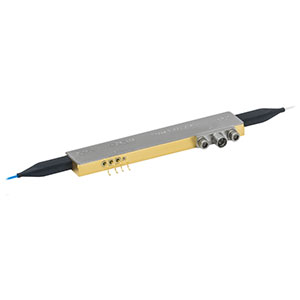

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#plot all signals in one plot
def plot_signals(signals, num_points):
    fig, ax = plt.subplots(figsize=(10, 6))
    for signal in signals:
        ax.plot(signal[0:num_points])
    ax.set_xlabel('Samples')
    ax.set_ylabel('Value')
    ax.grid(True)
    plt.show()

def plot_signal_x_y(x, y):
    plt.figure(figsize=(10, 6))
    plt.plot(x, y)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Signal X vs Y')
    plt.grid(True)
    plt.show()

def plot_fft(signal, DAC_sampling_rate):
    N = len(signal)
    T = 1.0 / DAC_sampling_rate

    fft_values = np.fft.fft(signal)
    freq = np.fft.fftfreq(N, T)
    magnitude = np.abs(fft_values)

    # Use fftshift to center the spectrum around zero frequency
    freq_shifted = np.fft.fftshift(freq)
    magnitude_shifted = np.fft.fftshift(magnitude)

    max_magnitude_index = np.argmax(magnitude_shifted)
    peak_frequency = freq_shifted[max_magnitude_index] / 1e6 #for MHz
    peak_magnitude = magnitude_shifted[max_magnitude_index]

    print(f"The peak frequency is {peak_frequency:.2f} MHz with a magnitude of {peak_magnitude:.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(freq_shifted / 1e6, magnitude_shifted, linewidth=1)  # Convert to MHz for x-axis
    plt.title('Frequency Domain (Magnitude Spectrum)')
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Magnitude')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [3]:

sampling_rate = 1e8 # as defined in RF Data Converter IP - for now 100 MHz
amplitude = 2**14 #maximum number of bits the DAC can read
laser_frequency = 10e6 #target frequency in Hz
num_points = 2**16 #maximum number of points in bram
T = 1/sampling_rate 
X_axis = T * np.arange(0, num_points)

sin_values = amplitude * np.sin(2 * np.pi * laser_frequency * X_axis)

phases_to_test = [0, np.pi/4, np.pi/2, np.pi, 3*np.pi/2]
sin_values_with_phase_shift = [amplitude * np.sin(2 * np.pi * laser_frequency * X_axis + phase) for phase in phases_to_test]

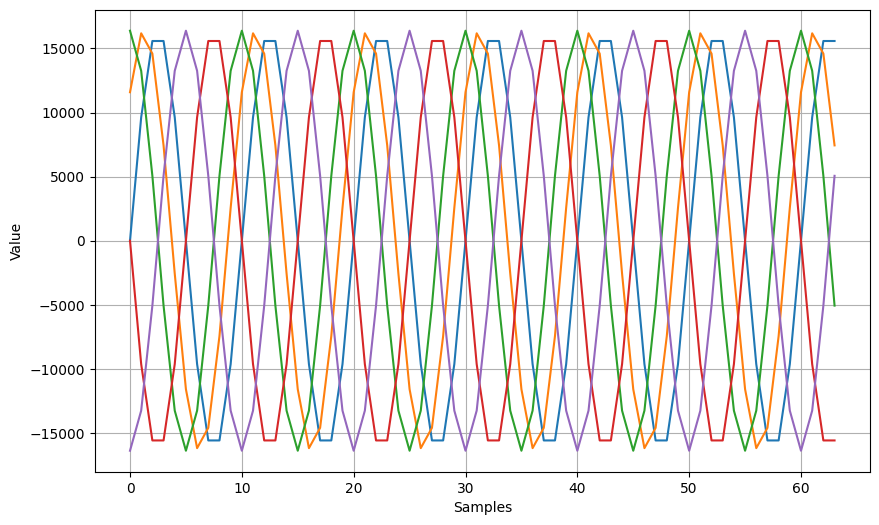

In [4]:
plot_signals(sin_values_with_phase_shift, 64)

In [5]:
modulation_frequency = 10e6
modulation_depth = np.pi / 2  
carrier_phase_term = 2 * np.pi * laser_frequency * X_axis

modulation_phase_term = modulation_depth * np.sin(2 * np.pi * modulation_frequency * X_axis)

modulated_signal = amplitude * np.cos(carrier_phase_term + modulation_phase_term)

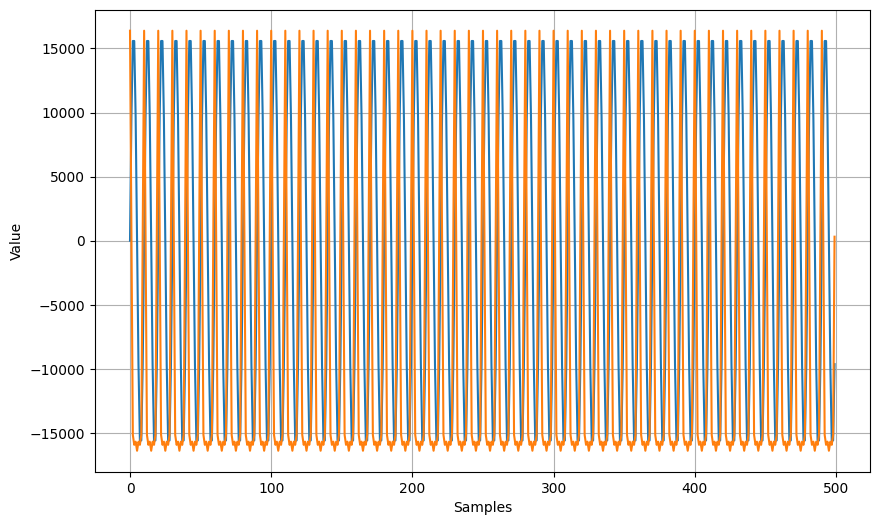

In [6]:
plot_signals([sin_values, modulated_signal], 500)

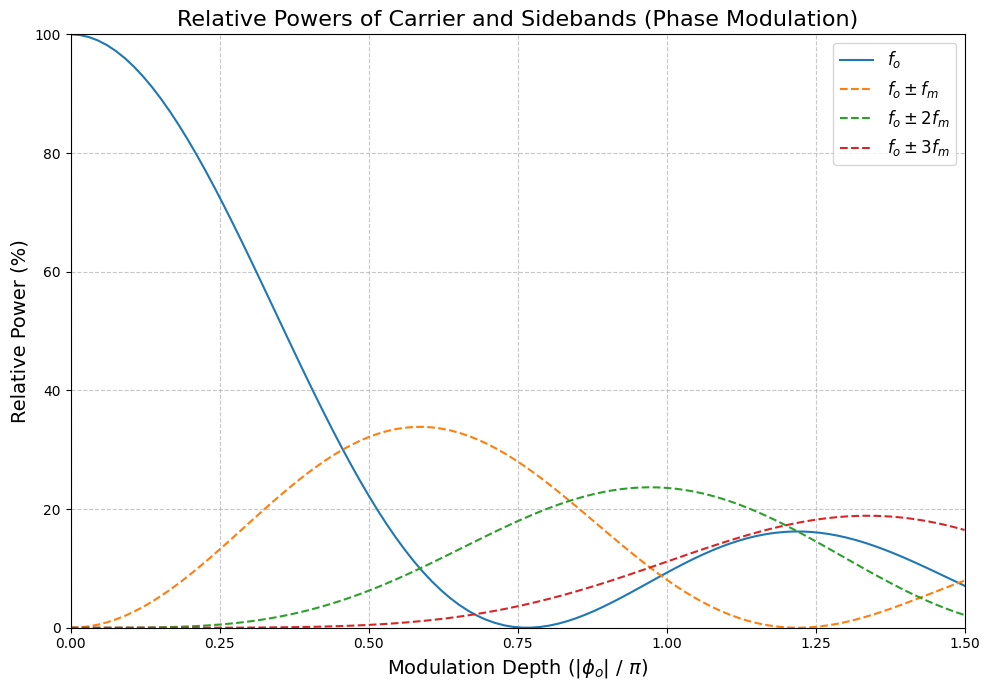

In [7]:
from scipy.special import jn
import numpy as np
import matplotlib.pyplot as plt

phi_vals = np.linspace(0, 1.5 * np.pi, 100)

# Calculate the squared values for relative power
carrier = jn(0, phi_vals)**2
first_sideband = jn(1, phi_vals)**2
second_sideband = jn(2, phi_vals)**2
third_sideband = jn(3, phi_vals)**2

# Plotting
plt.figure(figsize=(10, 7))

plt.plot(phi_vals / np.pi, carrier * 100, label='$f_o$')
plt.plot(phi_vals / np.pi, first_sideband * 100, label='$f_o \\pm f_m$', linestyle='--')
plt.plot(phi_vals / np.pi, second_sideband * 100, label='$f_o \\pm 2f_m$', linestyle='--')
plt.plot(phi_vals / np.pi, third_sideband * 100, label='$f_o \\pm 3f_m$', linestyle='--')

plt.title('Relative Powers of Carrier and Sidebands (Phase Modulation)', fontsize=16)
plt.xlabel('Modulation Depth (|$\\phi_o$| / $\\pi$)', fontsize=14)
plt.ylabel('Relative Power (%)', fontsize=14)
plt.xlim(0, 1.5)
plt.ylim(0, 100)
plt.xticks(np.arange(0, 1.75, 0.25))
plt.yticks(np.arange(0, 101, 20))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()



The peak frequency is -10.00 MHz with a magnitude of 406305001.47


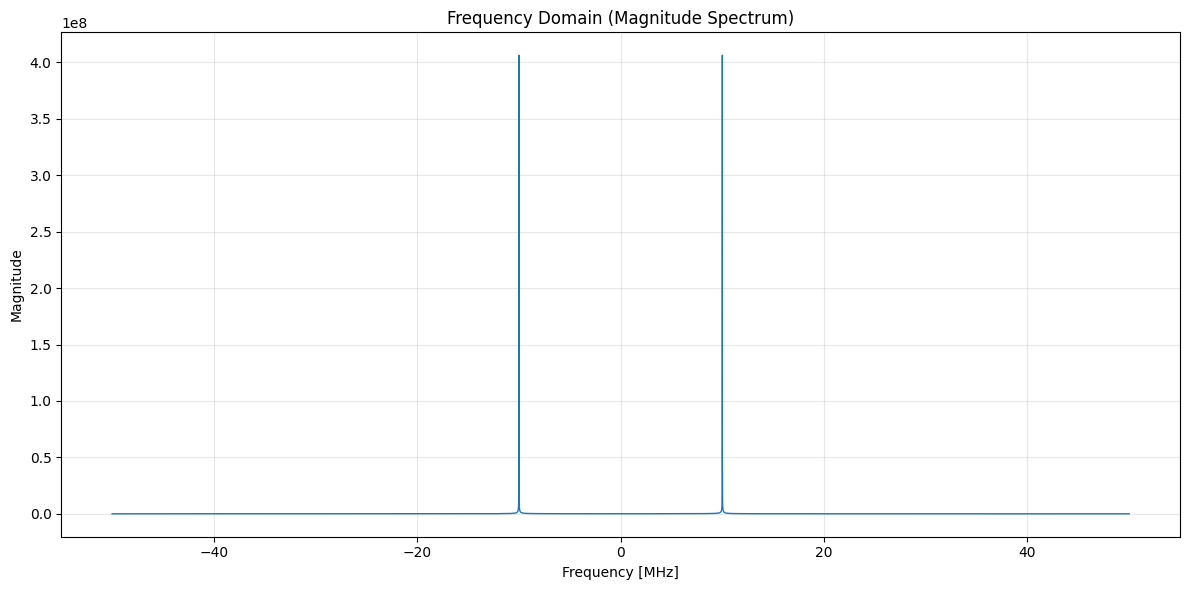

The peak frequency is 0.00 MHz with a magnitude of 608613129.77


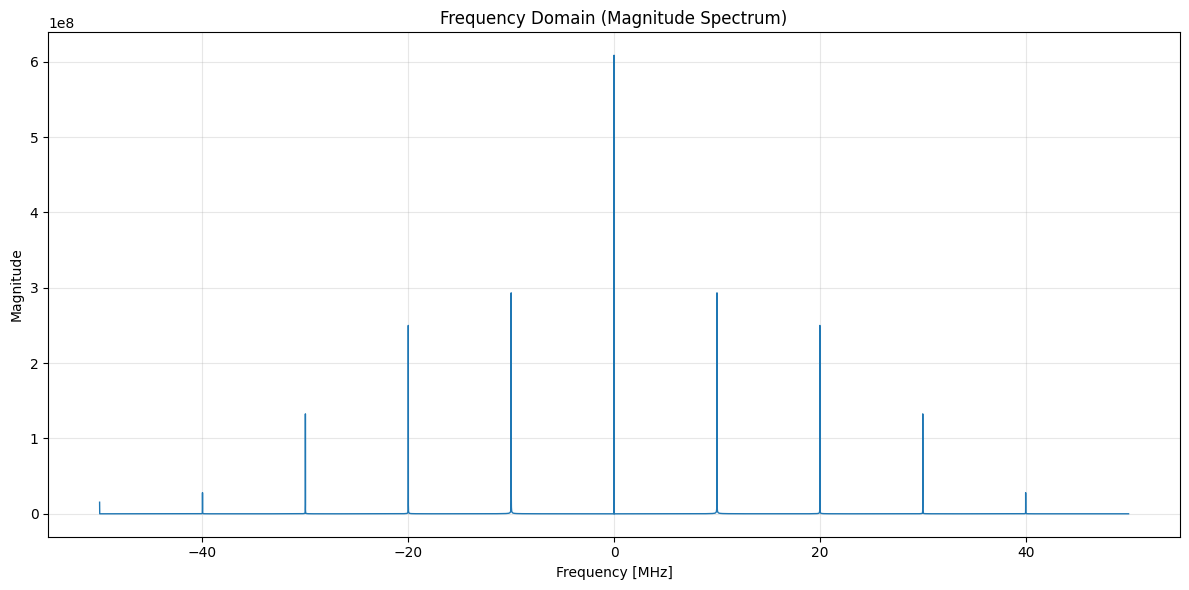

In [8]:
num_points = 65536

plot_fft(sin_values, sampling_rate)
plot_fft(modulated_signal, sampling_rate)

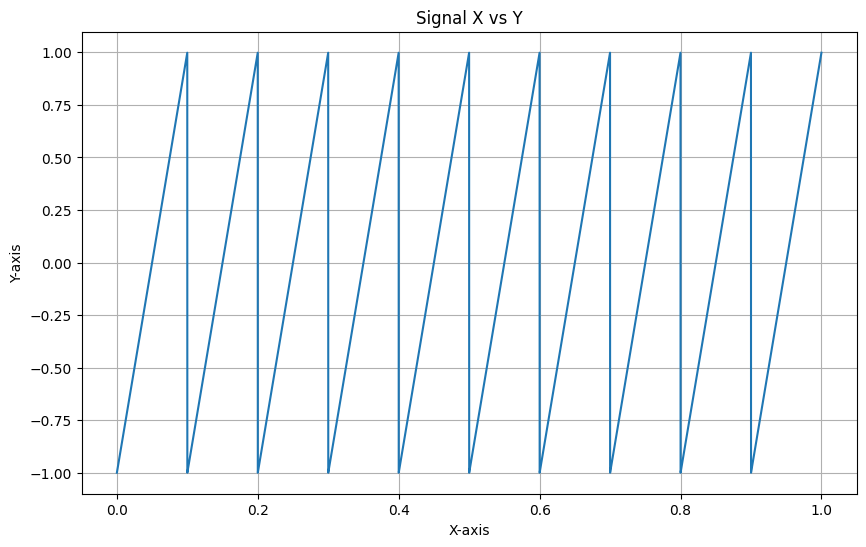

The peak frequency is -0.00 MHz with a magnitude of 3183.10


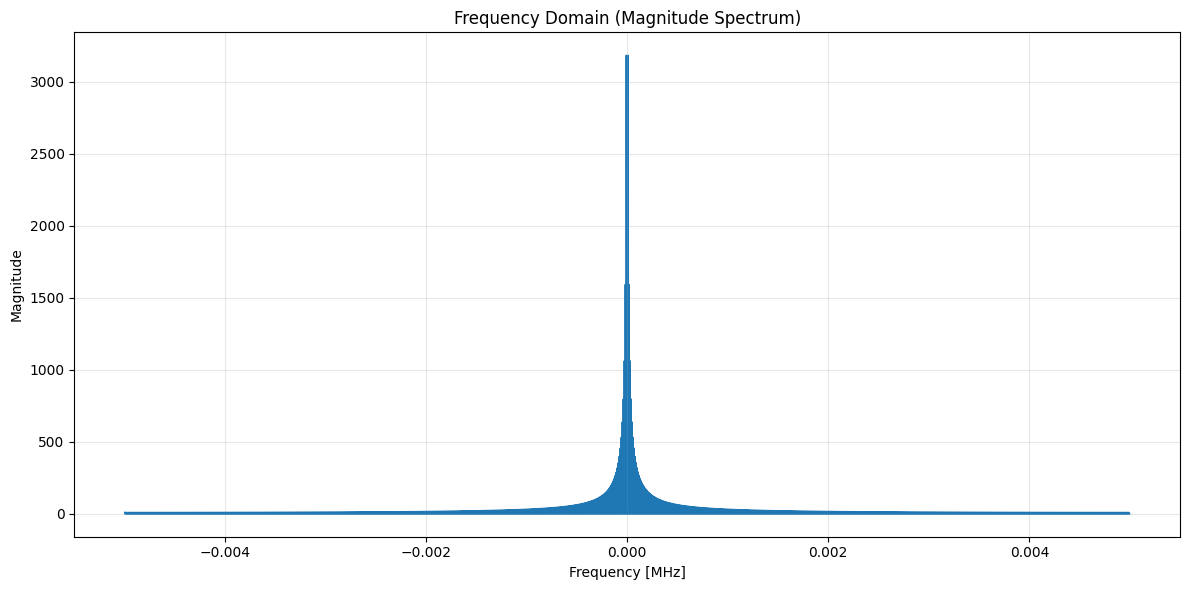

In [ ]:
from scipy.signal import sawtooth

#just some basic tests 
sample_rate = 10_000
target_freq_shift = sample_rate / 1000
duration = 1  # in seconds
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

wave = sawtooth(2 * np.pi * target_freq_shift * t)  # width=0.5 for triangle wave


plot_signal_x_y(t, wave)
plot_fft(wave, sample_rate)

Target frequency: 10 Hz
DC component (mean): -0.001000
Signal range: -1.000 to 0.998


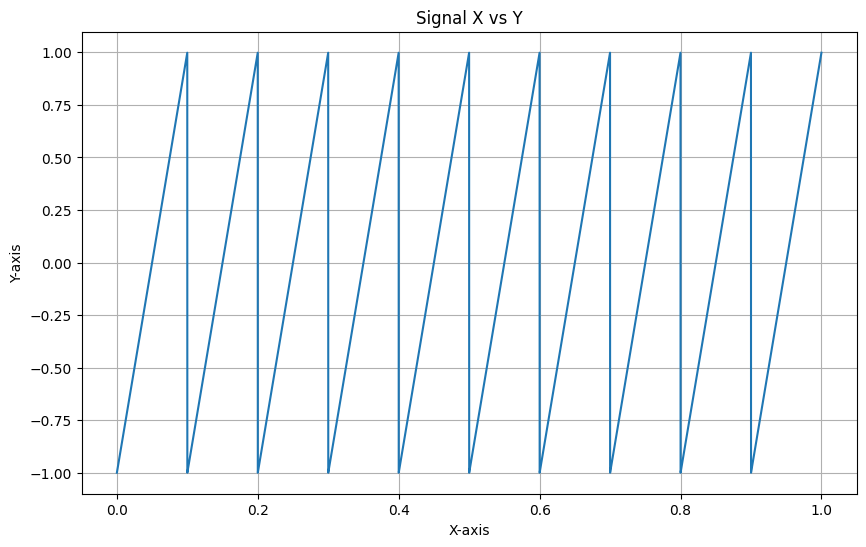

The peak frequency is -0.00 MHz with a magnitude of 3183.10


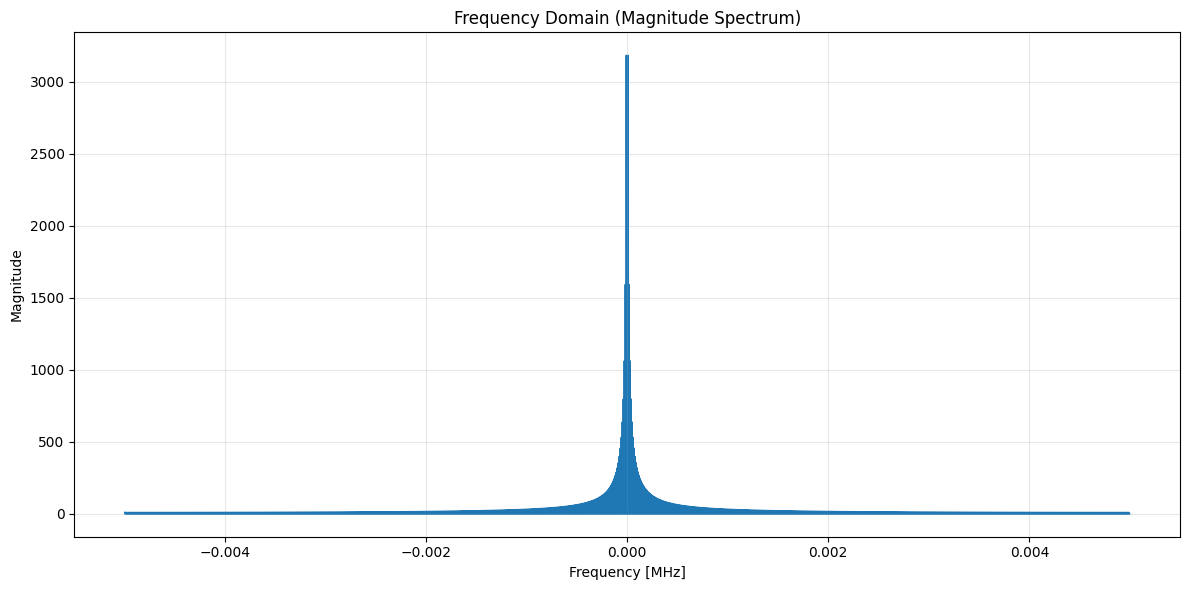

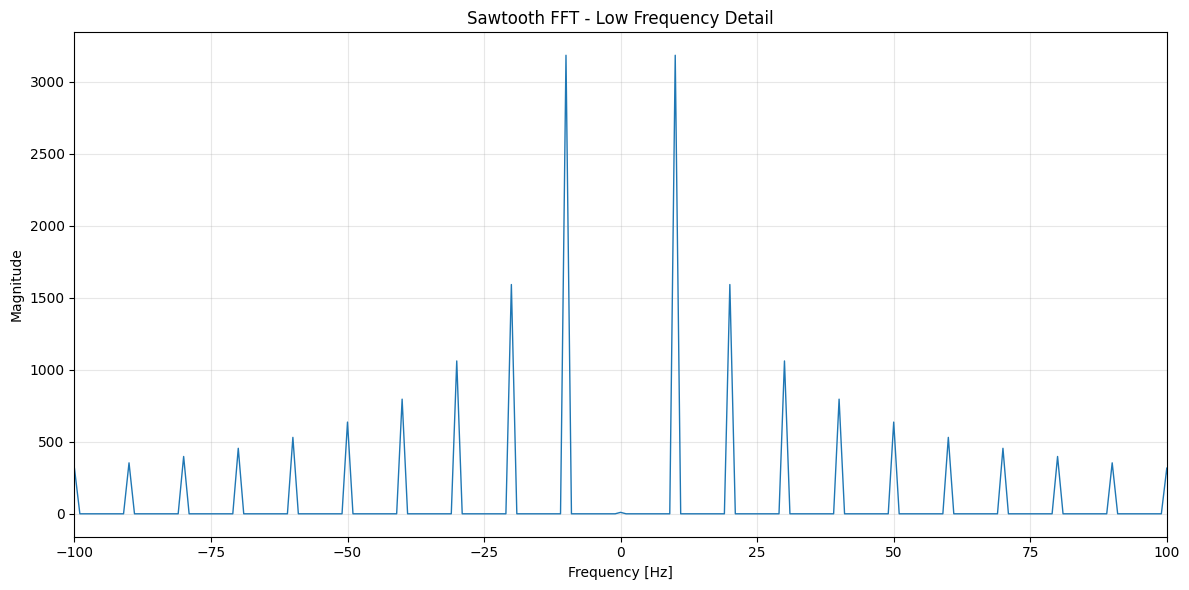

In [10]:
def analyze_sawtooth(sample_rate, target_freq_shift, duration=1):
    """
    Generate and analyze a sawtooth wave with detailed FFT analysis
    """
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    wave = sawtooth(2 * np.pi * target_freq_shift * t)
    
    # Print signal characteristics
    print(f"Target frequency: {target_freq_shift} Hz")
    print(f"DC component (mean): {np.mean(wave):.6f}")
    print(f"Signal range: {np.min(wave):.3f} to {np.max(wave):.3f}")
    
    # Plot time domain
    plot_signal_x_y(t, wave)
    
    # Plot full FFT
    plot_fft(wave, sample_rate)
    
    # Plot detailed low frequency view
    plt.figure(figsize=(12, 6))
    freq_shifted = np.fft.fftshift(np.fft.fftfreq(len(wave), 1/sample_rate))
    magnitude_shifted = np.fft.fftshift(np.abs(np.fft.fft(wave)))
    plt.plot(freq_shifted, magnitude_shifted, linewidth=1)
    plt.xlim(-100, 100)  # Zoom in to see low frequency content
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude')
    plt.title('Sawtooth FFT - Low Frequency Detail')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


analyze_sawtooth(sample_rate=10_000, target_freq_shift=10)